In [1]:
# We will read from this file for FFT
file_str = "/home/xilinx/jupyter_notebooks/pynq-182/burn_house_real.wav"

In [2]:
# Overlay imports
from pynq import Overlay
from pynq import allocate

# Random import
import random

# Imports for Matplotlib
%matplotlib notebook
import struct
import wave
import numpy as np
import matplotlib
from scipy.fftpack import fft
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [3]:
# Load Overlay
overlay = Overlay('/home/xilinx/pynq/overlays/fft2/fft.bit')

In [4]:
# Import wav file and extract required variables
wav_path = file_str 

with wave.open(wav_path, 'r') as wav_file:
    raw_frames = wav_file.readframes(-1)
    num_frames = wav_file.getnframes()
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()

temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8)
temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, 
                                                    sample_width)
temp_buffer[:, :, sample_width:] = \
    (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255
frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])
data = frames[:, 0]

print("Data Length:", len(data))
print("Number of frames:", num_frames)
print("Split:", len(raw_frames)/num_frames)
print("Sample Rate:", sample_rate)
print("Frames/Sample:", num_frames/sample_rate)

# Set number of color updates per second
freq_read_per_sec = 5

Data Length: 1440000
Number of frames: 1440000
Split: 6.0
Sample Rate: 48000
Frames/Sample: 30.0


In [5]:
# Set our length for FFT to 1024 entries
length = 1024

# Load overlay
dma = overlay.FFT.axi_dma_0

# Allocate space for buffers
in_buffer = allocate(shape=(length,), dtype=np.int32)
out_buffer = allocate(shape=(length,), dtype=np.int32)

In [6]:
# Define kernel function for DMA transfer / FFT
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Generate random array of values for FFT
in_buffer[:] = [random.randint(0,length) for i in range(1, length+1)]

In [8]:
%%timeit

# Comparison of single FFT in Software
np.fft.fft(in_buffer)

1000 loops, best of 3: 705 µs per loop


In [9]:
%%timeit

# Comparison of single FFT in Hardware
run_kernel()

1000 loops, best of 3: 342 µs per loop


In [10]:
%%timeit
# Comparison of full FFT in Software

for i in range(len(data)//(sample_rate//freq_read_per_sec)):
    curr = data[i*(sample_rate//freq_read_per_sec):(i+1)*(sample_rate//freq_read_per_sec)]
    
    for i in range(9):
        w = np.fft.fft(curr[i*1024:(i+1)*1024])
        freqs = np.fft.fftfreq(len(w))

        idx = np.argmax(np.abs(w))
        freq = freqs[idx]
        freq_in_hertz = abs(freq * sample_rate)

1 loop, best of 3: 1.68 s per loop


In [11]:
%%timeit
# Comparison of full FFT in Hardware

for i in range(len(data)//(sample_rate//freq_read_per_sec)):
    curr = data[i*(sample_rate//freq_read_per_sec):(i+1)*(sample_rate//freq_read_per_sec)]
    
    for i in range(9):
        # Array assignment taKes a long time here unfortunately
        in_buffer[:] = curr[i*1024:(i+1)*1024]
        run_kernel()

        idx = np.argmax(np.abs(out_buffer))
        freq = out_buffer[idx]
        freq_in_hertz = abs(freq * sample_rate)/1000000

1 loop, best of 3: 1.6 s per loop


<IPython.core.display.Javascript object>


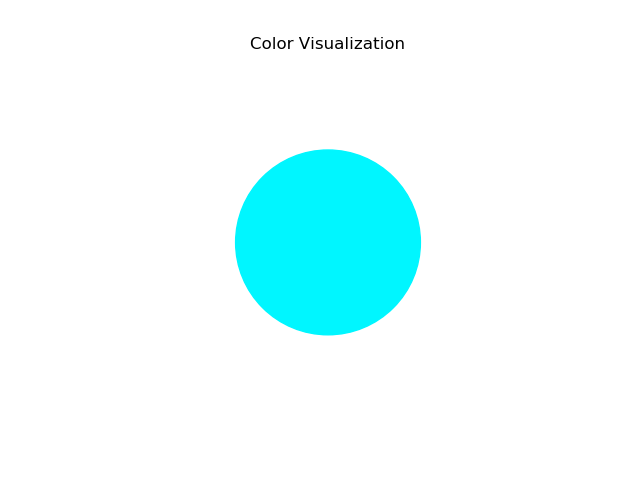

In [12]:
# Demonstration of FFT with Matplotlib visualization

# Normalize our frequencies to proper range
norm = matplotlib.colors.Normalize(vmin=1000, vmax=2500, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.gist_rainbow)

# Set up graph
fig = plt.figure() 
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10)) 
ax.set_aspect('equal')
circle = plt.Circle((0,0), 5, color='b')
ax.add_patch(circle)
plt.axis('off')
ax.set_title("Color Visualization")

# Function to update circle color
def updateCircleColor(circle, color):
    circle.set_color(color)
    
    return circle,

# Main function responsible for animating Matplotlib graph
def main(i, circle):
    curr = data[i*(sample_rate//freq_read_per_sec):(i+1)*(sample_rate//freq_read_per_sec)]

    maximal_freq = 0
    
    for i in range(9):
        in_buffer[:] = curr[i*1024:(i+1)*1024]
        run_kernel()
        w = out_buffer

        idx = np.argmax(np.abs(w))
        freq = w[idx]
        freq_in_hertz = abs(freq * sample_rate)/1000000
        
        if freq_in_hertz > maximal_freq:
            maximal_freq = freq_in_hertz
                
    color = mapper.to_rgba(maximal_freq)

    return updateCircleColor(circle, color)
    
# Run animation loop to update color of circle
anim = animation.FuncAnimation(fig, main, fargs=(circle, ), blit=True, interval=110)
plt.show()

In [ ]:
del in_buffer, out_buffer